In [28]:
import flair
import pandas as pd
import torch as pt
import requests
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import tweepy
import numpy as np

In [4]:
# Combining different tweets files into one, source --> https://www.kaggle.com/smid80/coronavirus-covid19-tweets
files = ["tweets/2020-03-29 Coronavirus Tweets.CSV",
         "tweets/2020-03-30 Coronavirus Tweets.CSV",
        "tweets/2020-03-31 Coronavirus Tweets.CSV",
        "tweets/2020-04-01 Coronavirus Tweets.CSV",
        "tweets/2020-04-02 Coronavirus Tweets.CSV",
        "tweets/2020-04-03 Coronavirus Tweets.CSV",
        "tweets/2020-04-04 Coronavirus Tweets.CSV",
        "tweets/2020-04-05 Coronavirus Tweets.CSV",
        "tweets/2020-04-06 Coronavirus Tweets.CSV",
        "tweets/2020-04-07 Coronavirus Tweets.CSV",
        "tweets/2020-04-08 Coronavirus Tweets.CSV",
        "tweets/2020-04-09 Coronavirus Tweets.CSV",
        "tweets/2020-04-10 Coronavirus Tweets.CSV",
        "tweets/2020-04-11 Coronavirus Tweets.CSV",
        "tweets/2020-04-12 Coronavirus Tweets.CSV",
        "tweets/2020-04-13 Coronavirus Tweets.CSV",
        "tweets/2020-04-14 Coronavirus Tweets.CSV",
        "tweets/2020-04-15 Coronavirus Tweets.CSV"]

dfs = []
count = 1
for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0)
    # Sorting by most favourited tweets
    df = df.sort_values(by='favourites_count', ascending=False)
    # Collecting first 10k tweets
    dfs.append(df.head(1000))
    print("Done ",count)
    count = count + 1

frame = pd.concat(dfs, axis=0, ignore_index=True)

frame.head()

Done  1
Done  2
Done  3
Done  4
Done  5
Done  6
Done  7
Done  8
Done  9
Done  10
Done  11
Done  12
Done  13
Done  14
Done  15
Done  16
Done  17
Done  18


,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1244331231765987331,63514682,2020-03-29T18:30:58Z,David_Leavitt,Seeing your friends after the #coronavirus qua...,Twitter Web App,NaN,NaN,NaN,False,...,48,NaN,NaN,NaN,216960,4684,NaN,2009-08-06T19:23:18Z,True,en
1,1244318281814679557,63514682,2020-03-29T17:39:31Z,David_Leavitt,ALL non-Rhode Island plated cards are being pu...,Twitter Web App,NaN,NaN,NaN,False,...,28,NaN,NaN,NaN,216961,4684,NaN,2009-08-06T19:23:18Z,True,en
2,1244398549636386825,63514682,2020-03-29T22:58:28Z,David_Leavitt,People are complaining about another 30 days o...,Twitter for iPhone,NaN,NaN,NaN,False,...,527,US,"Providence, RI",city,216928,5145,NaN,2009-08-06T19:23:18Z,True,en
3,1244363137576509441,63514682,2020-03-29T20:37:45Z,David_Leavitt,"Literally within hours of each other:\n\n""We’r...",Twitter Web App,NaN,NaN,NaN,False,...,433,NaN,NaN,NaN,216930,5145,NaN,2009-08-06T19:23:18Z,True,en
4,1244400077159960577,63514682,2020-03-29T23:04:32Z,David_Leavitt,WTF are you rambling about @realDonaldTrump?\n...,Twitter for iPhone,NaN,NaN,NaN,False,...,176,US,"Providence, RI",city,216928,5145,NaN,2009-08-06T19:23:18Z,True,en


In [5]:
# Cleaning out irrelevant data
frame = frame.drop(['source',
            'reply_to_status_id',
            'reply_to_user_id',
            'reply_to_screen_name',
            'is_quote',
           'is_retweet',
           'retweet_count',
           'country_code',
           'country_code',
            'place_full_name',
            'place_type',
            'followers_count',
            'friends_count',
            'account_lang',
            'account_created_at',
            'verified'], axis=1)

frame.head()

,status_id,user_id,created_at,screen_name,text,favourites_count,lang
0,1244331231765987331,63514682,2020-03-29T18:30:58Z,David_Leavitt,Seeing your friends after the #coronavirus qua...,1536144,en
1,1244318281814679557,63514682,2020-03-29T17:39:31Z,David_Leavitt,ALL non-Rhode Island plated cards are being pu...,1536125,en
2,1244398549636386825,63514682,2020-03-29T22:58:28Z,David_Leavitt,People are complaining about another 30 days o...,1536011,en
3,1244363137576509441,63514682,2020-03-29T20:37:45Z,David_Leavitt,"Literally within hours of each other:\n\n""We’r...",1536011,en
4,1244400077159960577,63514682,2020-03-29T23:04:32Z,David_Leavitt,WTF are you rambling about @realDonaldTrump?\n...,1536011,en


In [6]:
# Remove row indexes for which column lang is not english
indexNonEnglish = frame[ frame['lang'] != 'en' ].index
frame.drop(indexNonEnglish , inplace=True)

frame.head()

,status_id,user_id,created_at,screen_name,text,favourites_count,lang
0,1244331231765987331,63514682,2020-03-29T18:30:58Z,David_Leavitt,Seeing your friends after the #coronavirus qua...,1536144,en
1,1244318281814679557,63514682,2020-03-29T17:39:31Z,David_Leavitt,ALL non-Rhode Island plated cards are being pu...,1536125,en
2,1244398549636386825,63514682,2020-03-29T22:58:28Z,David_Leavitt,People are complaining about another 30 days o...,1536011,en
3,1244363137576509441,63514682,2020-03-29T20:37:45Z,David_Leavitt,"Literally within hours of each other:\n\n""We’r...",1536011,en
4,1244400077159960577,63514682,2020-03-29T23:04:32Z,David_Leavitt,WTF are you rambling about @realDonaldTrump?\n...,1536011,en


In [7]:
import re
# Clean the text in all tweets
def cleanText(row):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    covid = re.compile(r"(?i)#Covid(?=\b)")
    coronavirus = re.compile(r"(?i)#Coronavirus(?=\b)")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    
    text = row["text"]
    text = whitespace.sub(' ', text)
    text = web_address.sub('', text)
    text = covid.sub('Covid', text)
    text = coronavirus.sub('Coronavirus', text)
    text = user.sub('', text)
    return text

frame["cleanText"] = frame.apply(lambda row: cleanText(row), axis = 1)

frame.head()

,status_id,user_id,created_at,screen_name,text,favourites_count,lang,cleanText
0,1244331231765987331,63514682,2020-03-29T18:30:58Z,David_Leavitt,Seeing your friends after the #coronavirus qua...,1536144,en,Seeing your friends after the Coronavirus quar...
1,1244318281814679557,63514682,2020-03-29T17:39:31Z,David_Leavitt,ALL non-Rhode Island plated cards are being pu...,1536125,en,ALL non-Rhode Island plated cards are being pu...
2,1244398549636386825,63514682,2020-03-29T22:58:28Z,David_Leavitt,People are complaining about another 30 days o...,1536011,en,People are complaining about another 30 days o...
3,1244363137576509441,63514682,2020-03-29T20:37:45Z,David_Leavitt,"Literally within hours of each other:\n\n""We’r...",1536011,en,"Literally within hours of each other: ""We’re g..."
4,1244400077159960577,63514682,2020-03-29T23:04:32Z,David_Leavitt,WTF are you rambling about @realDonaldTrump?\n...,1536011,en,WTF are you rambling about ? It’s when the PEO...


In [8]:
frame.loc[0]["text"]

'Seeing your friends after the #coronavirus quarantine ends https://t.co/AQrU0s0ScV'

In [9]:
frame.loc[0]["cleanText"]

'Seeing your friends after the Coronavirus quarantine ends '

In [10]:
# Applying sentiment analysis on the cleaned tweet texts in batches

sentiment_model = flair.models.TextClassifier.load('en-sentiment')

def getSentiment(row): 
    sentence = flair.data.Sentence(row["cleanText"])
    sentiment_model.predict(sentence)
    return sentence.labels[0].value  # 'POSITIVE' or 'NEGATIVE
   
def getSentimentProbability(row): 
    sentence = flair.data.Sentence(row["cleanText"])
    sentiment_model.predict(sentence)
    return sentence.labels[0].score  # numerical value 0-1

dfs = []

for i in range(0,len(frame),len(frame)//10):
    newFrame = frame[i:i+len(frame)//10]
    filename = "Batch" + str(i) + ".csv"
    newFrame["sentiment"] = newFrame.apply(lambda row: getSentiment(row), axis = 1)
    newFrame["sentimentProbability"] = newFrame.apply(lambda row: getSentimentProbability(row), axis = 1)
    dfs.append(newFrame)
    newFrame.to_csv(filename, index=False)
    print("Done Batch:,", i)


2021-06-30 12:37:55,581 loading file /Users/saadimran/.flair/models/sentiment-en-mix-distillbert_4.pt


<ipython-input-10-8e5a90cfa9e9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newFrame["sentiment"] = newFrame.apply(lambda row: getSentiment(row), axis = 1)
<ipython-input-10-8e5a90cfa9e9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newFrame["sentimentProbability"] = newFrame.apply(lambda row: getSentimentProbability(row), axis = 1)


Done Batch:, 0
Done Batch:, 1123
Done Batch:, 2246
Done Batch:, 3369
Done Batch:, 4492
Done Batch:, 5615
Done Batch:, 6738
Done Batch:, 7861
Done Batch:, 8984
Done Batch:, 10107
Done Batch:, 11230


In [11]:
# Stitching the batches back together

frame = pd.concat(dfs, axis=0, ignore_index=True)
frame.head()

,status_id,user_id,created_at,screen_name,text,favourites_count,lang,cleanText,sentiment,sentimentProbability
0,1244331231765987331,63514682,2020-03-29T18:30:58Z,David_Leavitt,Seeing your friends after the #coronavirus qua...,1536144,en,Seeing your friends after the Coronavirus quar...,POSITIVE,0.999269
1,1244318281814679557,63514682,2020-03-29T17:39:31Z,David_Leavitt,ALL non-Rhode Island plated cards are being pu...,1536125,en,ALL non-Rhode Island plated cards are being pu...,NEGATIVE,0.999442
2,1244398549636386825,63514682,2020-03-29T22:58:28Z,David_Leavitt,People are complaining about another 30 days o...,1536011,en,People are complaining about another 30 days o...,NEGATIVE,0.992927
3,1244363137576509441,63514682,2020-03-29T20:37:45Z,David_Leavitt,"Literally within hours of each other:\n\n""We’r...",1536011,en,"Literally within hours of each other: ""We’re g...",NEGATIVE,0.999743
4,1244400077159960577,63514682,2020-03-29T23:04:32Z,David_Leavitt,WTF are you rambling about @realDonaldTrump?\n...,1536011,en,WTF are you rambling about ? It’s when the PEO...,NEGATIVE,0.998832


In [12]:
# Total tweets analysed

len(frame)

11234

In [67]:
# Applying negative to all negative values for plotting

def getNormalisedProbability(row):
    if row["sentiment"] == "POSITIVE":
        return row["sentimentProbability"]
    return -1 * row["sentimentProbability"]


frame["sentimentProbability"] = frame.apply(lambda row: getNormalisedProbability(row), axis=1)

frame.head()

,status_id,user_id,created_at,screen_name,text,favourites_count,lang,cleanText,sentiment,sentimentProbability
0,1244331231765987331,63514682,2020-03-29T18:30:58Z,David_Leavitt,Seeing your friends after the #coronavirus qua...,1536144,en,Seeing your friends after the Coronavirus quar...,POSITIVE,0.999269
1,1244318281814679557,63514682,2020-03-29T17:39:31Z,David_Leavitt,ALL non-Rhode Island plated cards are being pu...,1536125,en,ALL non-Rhode Island plated cards are being pu...,NEGATIVE,-0.999442
2,1244398549636386825,63514682,2020-03-29T22:58:28Z,David_Leavitt,People are complaining about another 30 days o...,1536011,en,People are complaining about another 30 days o...,NEGATIVE,-0.992927
3,1244363137576509441,63514682,2020-03-29T20:37:45Z,David_Leavitt,"Literally within hours of each other:\n\n""We’r...",1536011,en,"Literally within hours of each other: ""We’re g...",NEGATIVE,-0.999743
4,1244400077159960577,63514682,2020-03-29T23:04:32Z,David_Leavitt,WTF are you rambling about @realDonaldTrump?\n...,1536011,en,WTF are you rambling about ? It’s when the PEO...,NEGATIVE,-0.998832


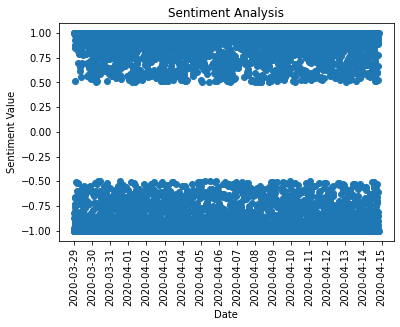

In [71]:
# Rough Scatter Plot of sentiments over time

dates = ["2020-03-29",
         "2020-03-30",
        "2020-03-31",
        "2020-04-01",
        "2020-04-02",
        "2020-04-03",
        "2020-04-04",
        "2020-04-05",
        "2020-04-06",
        "2020-04-07",
        "2020-04-08",
        "2020-04-09",
        "2020-04-10",
        "2020-04-11",
        "2020-04-12",
        "2020-04-13",
        "2020-04-14",
        "2020-04-15"]

def createPlot(frame):
    xticks = dates
    length = len(frame)
    plt.xlabel("Date")
    plt.ylabel("Sentiment Value")
    x_pos = np.arange(0,length+1,length/(len(xticks)-1))
    data = plt.scatter(frame["created_at"],frame["sentimentProbability"])
    plt.xticks(x_pos, xticks,rotation="vertical")
    plt.title("Sentiment Analysis")
    plt.show()

createPlot(frame)